In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.preprocessing import QuantileTransformer
import numpy as np
import time
import tqdm

#Data Creation

In [ ]:
# Replace the file path with the correct path to your Excel file
file_path = '/content/drive/MyDrive/wpt/dataset/wptdataset2.xlsx'

df = pd.read_excel(file_path)

In [ ]:
col = df.columns[:]

In [ ]:
len(col)


12

In [ ]:
# fig, ax = plt.subplots(4,4, figsize=(25,25))
# ax = ax.ravel()
# k = 0
# # Define a list of colors to use
# colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']
# for i in range(4):
#     for j in range(4):
#         data = df[col[k]].values
#         ax[k].plot(list(range(len(data))), data, color=colors[k % len(colors)])  # Use a different color for each plot
#         ax[k].set_xlabel(col[k])
#         k += 1
# plt.show()

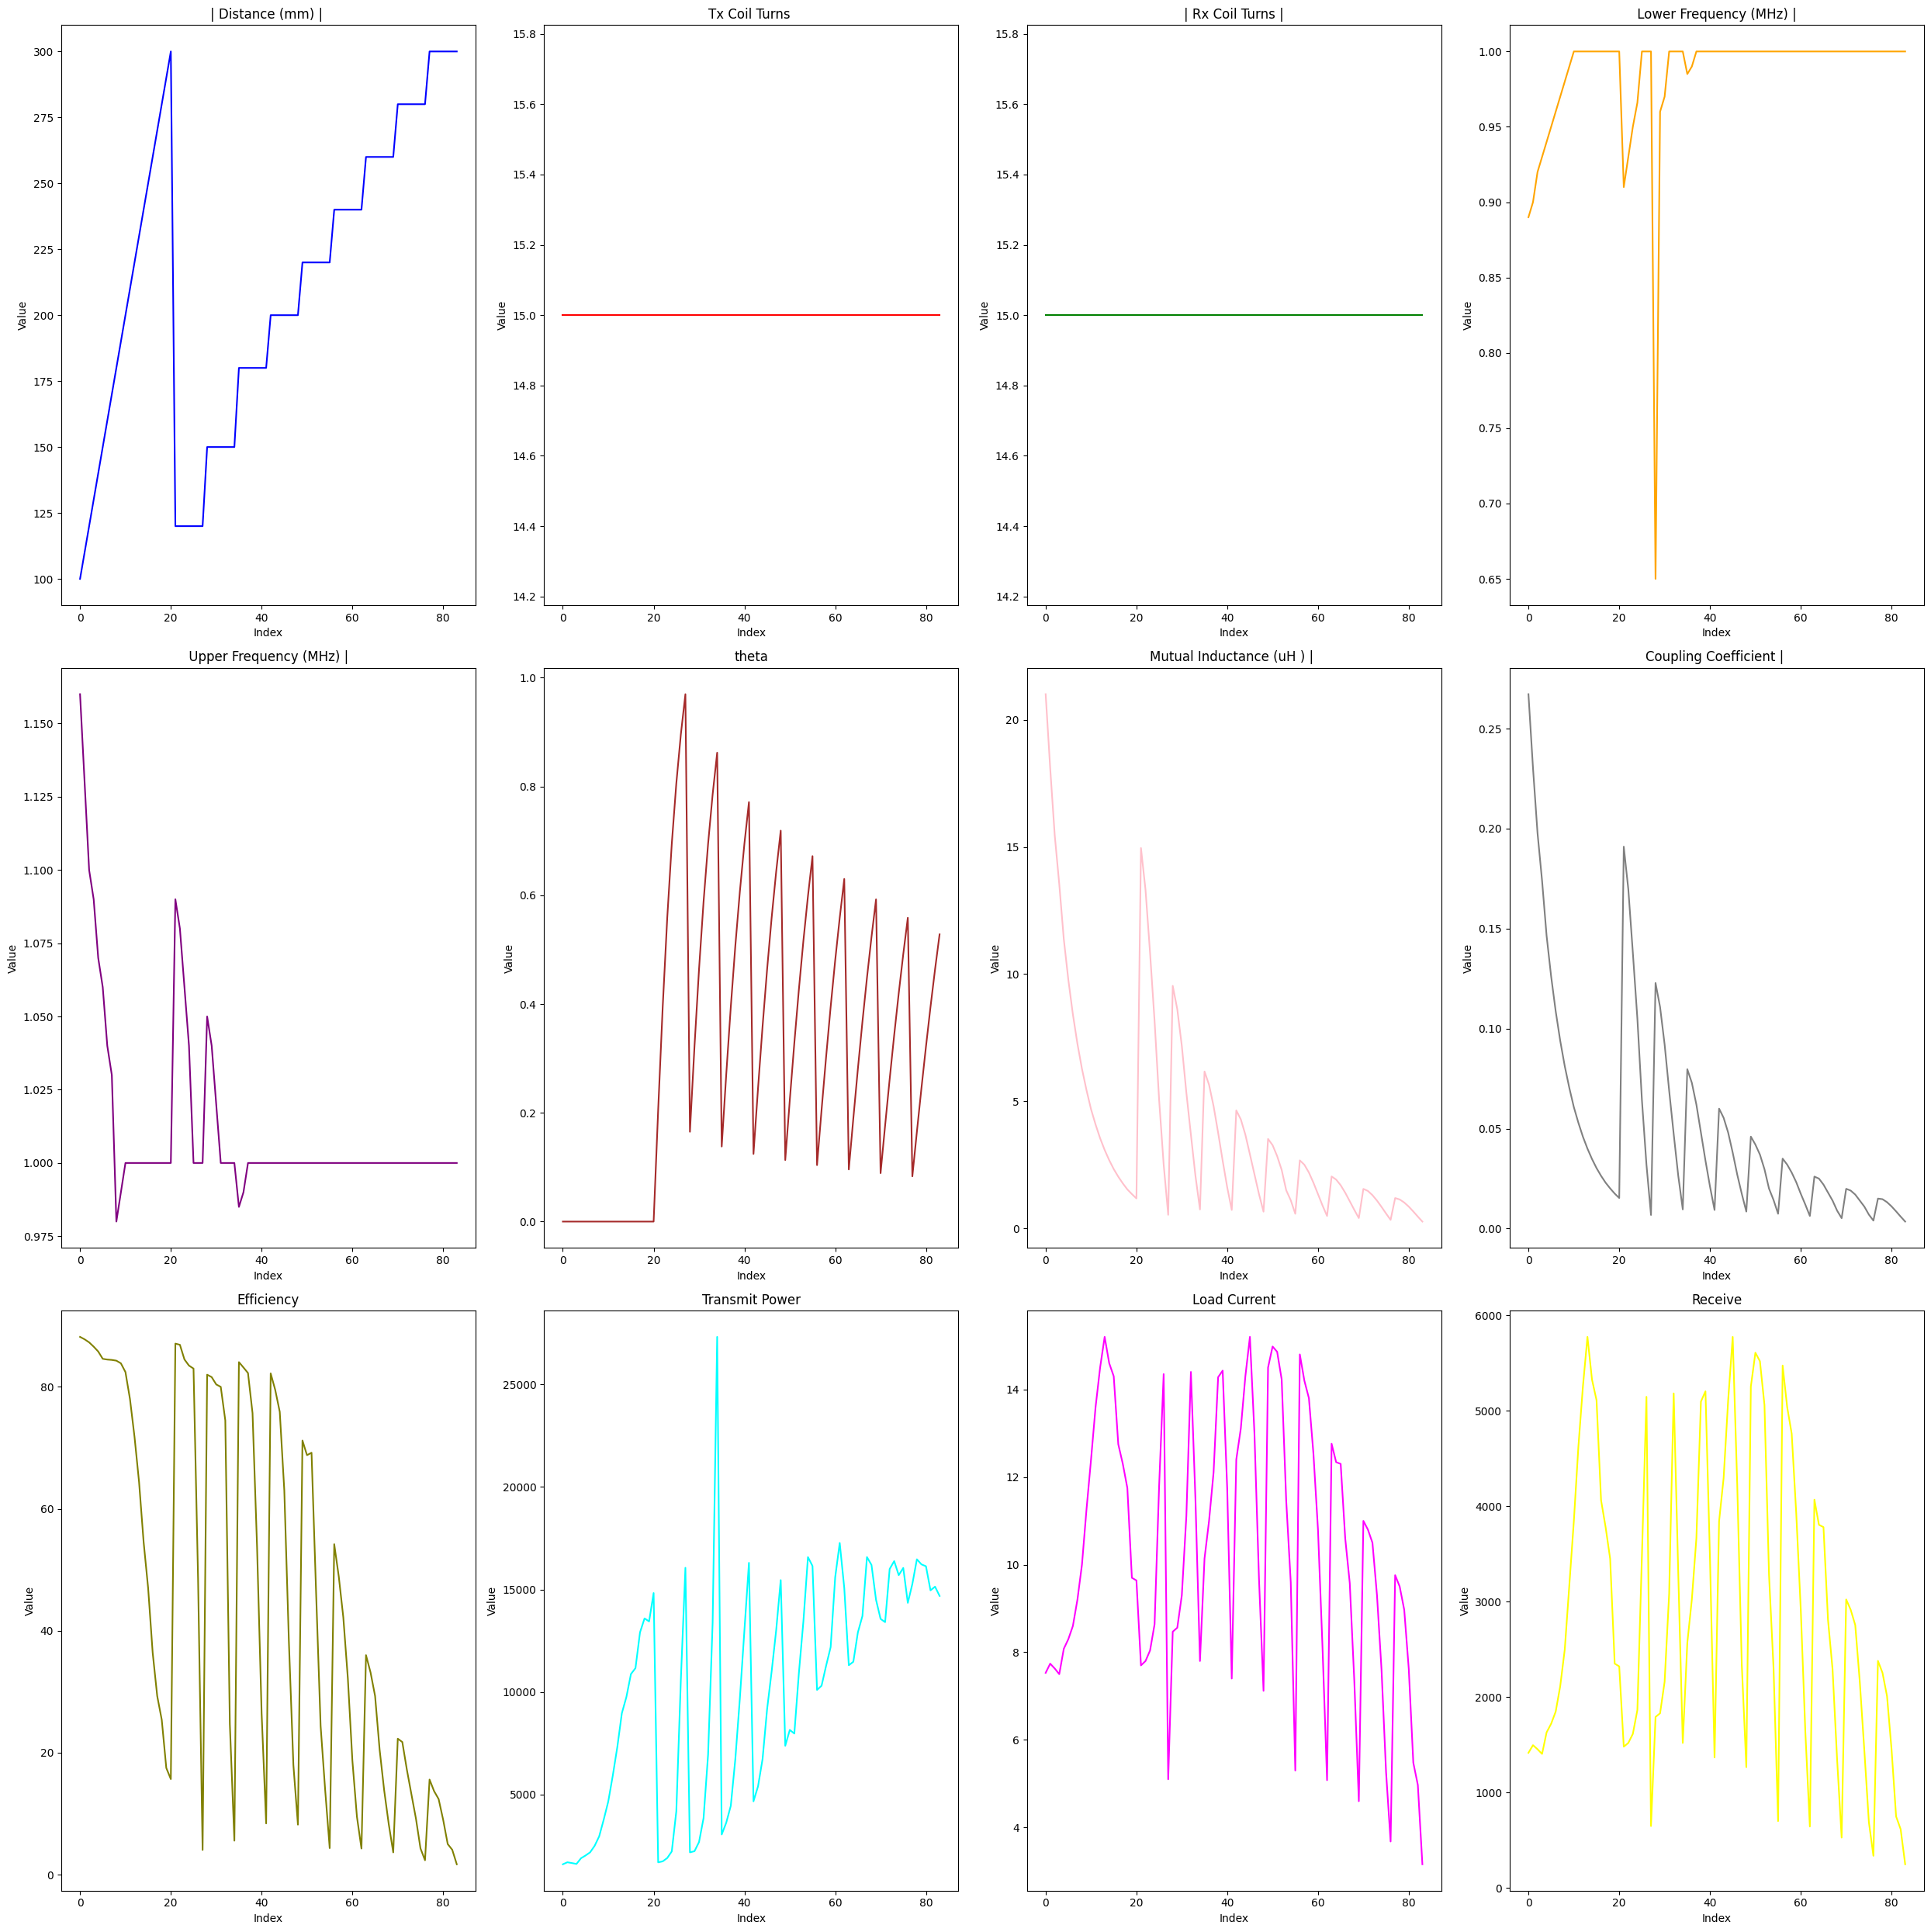

In [ ]:
import matplotlib.pyplot as plt

# Define your list of column names
col = df.columns  # Assuming your DataFrame's columns are in the correct order

# Calculate the number of rows and columns for the subplots
num_rows = (len(col) + 3) // 4  # Ceiling division
num_cols = min(len(col), 4)

# Create a grid of subplots
fig, ax = plt.subplots(num_rows, num_cols, figsize=(25, 25))
ax = ax.ravel()

# Define a list of colors to use
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']

for k in range(len(col)):
    data = df[col[k]].values
    ax[k].plot(list(range(len(data))), data, color=colors[k % len(colors)])
    ax[k].set_title(col[k])
    ax[k].set_xlabel('Index')
    ax[k].set_ylabel('Value')

# Turn off any remaining empty subplots
for k in range(len(col), num_rows * num_cols):
    ax[k].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
col[11]


'Receive'

In [ ]:
df[col[11]]

0     1417.5225
1     1497.6900
2     1455.4225
3     1406.2500
4     1632.1600
        ...    
79    2011.5225
80    1451.6100
81     750.7600
82     617.5225
83     249.6400
Name: Receive, Length: 84, dtype: float64

# Dataset creating

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


column_to_standardize = df[col[11]]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the column
standardized_column = scaler.fit_transform(column_to_standardize.values.reshape(-1, 1))

# Update the original DataFrame with the standardized column
df[col[11]] = standardized_column

In [ ]:
input_cols = col[0:11]
input_cols


Index(['| Distance (mm) | ', 'Tx Coil Turns ', '| Rx Coil Turns |',
       ' Lower Frequency (MHz) | ', ' Upper Frequency (MHz) | ', 'theta',
       'Mutual Inductance (uH ) | ', 'Coupling Coefficient | ', 'Efficiency',
       'Transmit Power', 'Load Current'],
      dtype='object')

In [ ]:

from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define your list of column names
input_cols = col[0:11] # Replace with your actual column names
output_col = col[11]  # Replace with your actual output column name


# Extract input features and output variable
X = df[input_cols]
y = df[output_col]

# Initialize the StandardScaler for input features
scaler = StandardScaler()

# Normalize the input features
X_normalized = scaler.fit_transform(X)


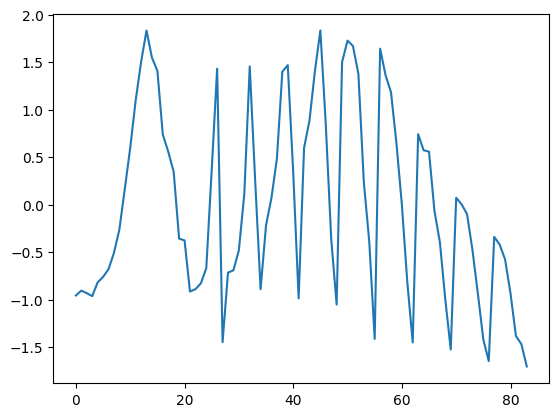

In [ ]:
plt.plot(y)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error



# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.2, random_state=42)


n_components = 4  # Number of components after PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Reshape the input data for the CNN-LSTM model
input_shape = (X_train_pca.shape[1], 1)  # (sequence_length, channels)
X_train = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
X_val= X_val_pca.reshape((X_val_pca.shape[0], X_val_pca.shape[1], 1))

In [ ]:
X_train_pca.shape

(67, 4)

In [ ]:
X_train.shape

(67, 4, 1)

In [ ]:
y_val

73   -0.478877
0    -0.956028
58    1.186155
22   -0.889729
12    1.503464
70    0.073891
10    0.598628
18    0.347192
4    -0.818509
65    0.559065
40    0.343429
47   -0.363352
35   -0.217316
81   -1.383226
55   -1.414307
54   -0.388057
33    0.254089
Name: Receive, dtype: float64

In [ ]:
input_shape


(4, 1)

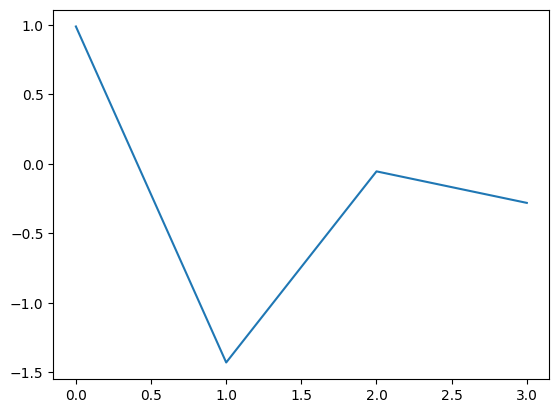

In [ ]:
plt.plot(X_train[1])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, Input, Multiply, Activation, RepeatVector, Permute
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.keras import regularizers

def build_attention_cnn_lstm_model(input_shape):
    model_input = Input(shape=input_shape)

    # Convolutional layers
    x = Conv1D(64, 3, activation='relu', padding='same')(model_input)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)

    # LSTM layer
    x = LSTM(64, return_sequences=True)(x)

    # Attention mechanism
    attention = Dense(1, activation='tanh')(x)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(64)(attention)
    attention = Permute([2, 1])(attention)

    # Apply attention
    attended_representation = Multiply()([x, attention])

    # Flatten and fully connected layers
    x = Flatten()(attended_representation)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    model_output = Dense(1, activation='softmax',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5))(x)  # Output layer for regression

    model = Model(inputs=model_input, outputs=model_output)
    return model

# Generate some example data (replace with your actual data)



# Build the attention-based CNN-LSTM model

model = build_attention_cnn_lstm_model(input_shape)



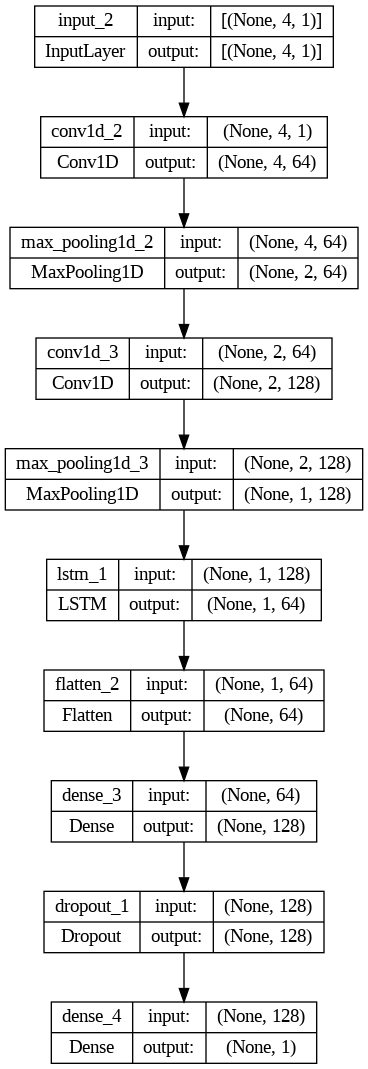

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=4, validation_data=(X_val, y_val))




Epoch 1/500
17/17 [==============================] - 4s 43ms/step - loss: 2.0212 - val_loss: 1.9166
Epoch 2/500
17/17 [==============================] - 0s 6ms/step - loss: 2.0212 - val_loss: 1.9166
Epoch 3/500
17/17 [==============================] - 0s 6ms/step - loss: 2.0212 - val_loss: 1.9166
Epoch 4/500
17/17 [==============================] - 0s 6ms/step - loss: 2.0212 - val_loss: 1.9166
Epoch 5/500
17/17 [==============================] - 0s 6ms/step - loss: 2.0212 - val_loss: 1.9166
Epoch 6/500
17/17 [==============================] - 0s 6ms/step - loss: 2.0212 - val_loss: 1.9166
Epoch 7/500
17/17 [==============================] - 0s 7ms/step - loss: 2.0212 - val_loss: 1.9166
Epoch 8/500
17/17 [==============================] - 0s 6ms/step - loss: 2.0212 - val_loss: 1.9166
Epoch 9/500
17/17 [==============================] - 0s 7ms/step - loss: 2.0212 - val_loss: 1.9166
Epoch 10/500
17/17 [==============================] - 0s 8ms/step - loss: 2.0212 - val_loss: 1.9166
Epoch 11

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4, 1)]       0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 4, 64)        256         ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 2, 64)       0           ['conv1d_2[0][0]']               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 2, 128)       24704       ['max_pooling1d_2[0][0]']        
                                                                                            

In [ ]:
# Evaluate the model
val_predictions = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
print(f"Validation MSE: {val_mse}")

1/1 [==============================] - 1s 612ms/step
Validation MSE: 0.00464062655151499


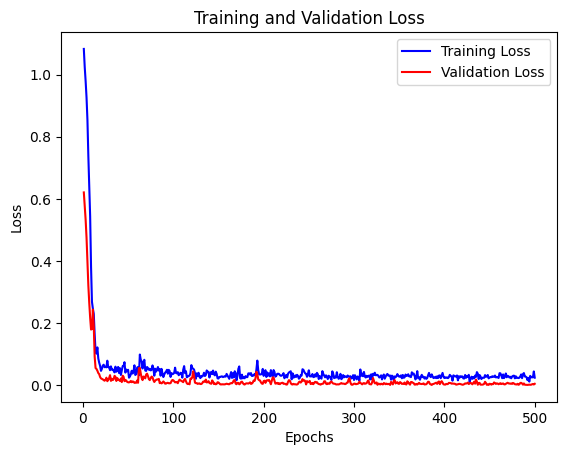

1/1 [==============================] - 0s 32ms/step - loss: 0.0046
Validation Loss: 0.004640626721084118
1/1 [==============================] - 0s 33ms/step


In [ ]:
# Plot the loss curve
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")

# You can use the trained model for predictions
predictions = model.predict(X_val)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ... (previous code for data splitting, model definition, and training)

# Evaluate the model
loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")

# Make predictions using the trained model
predictions = model.predict(X_val)

# Calculate additional evaluation metrics
mse = mean_squared_error(y_val, predictions)
r2 = r2_score(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

1/1 [==============================] - 0s 55ms/step - loss: 0.0046
Validation Loss: 0.004640626721084118
1/1 [==============================] - 0s 40ms/step
Mean Squared Error: 0.00464062655151499
R2 Score: 0.9929871560052782
Mean Absolute Error: 0.05822366682635511
Root Mean Squared Error: 0.06812214435493784


1/1 [==============================] - 0s 35ms/step


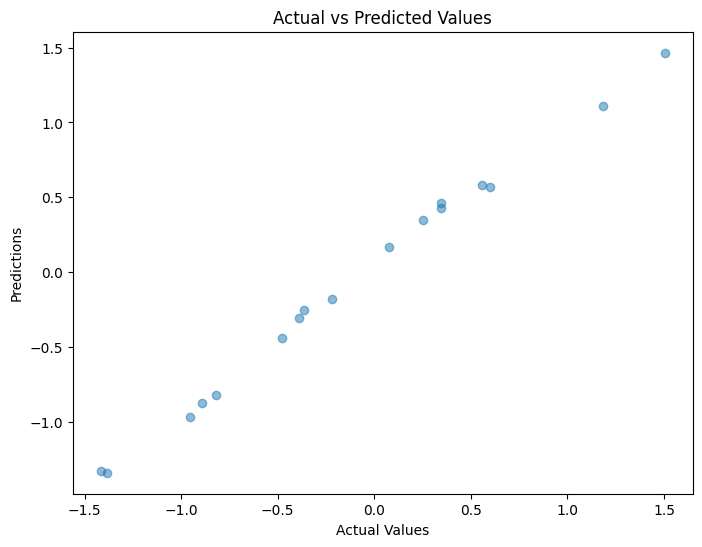

In [ ]:
predictions = model.predict(X_val)

# Create a scatter plot of predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Actual vs Predicted Values')
plt.show()

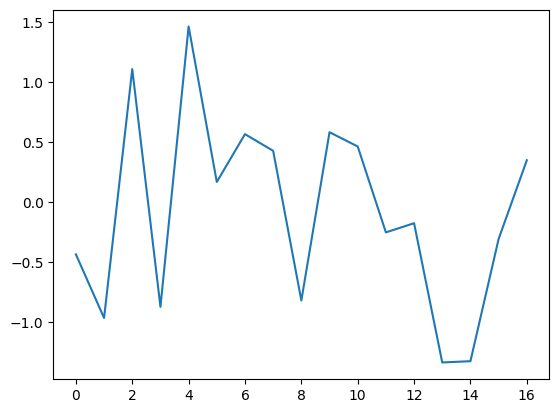

In [ ]:
plt.plot(predictions)


In [ ]:
 predictions.shape

(17, 1)

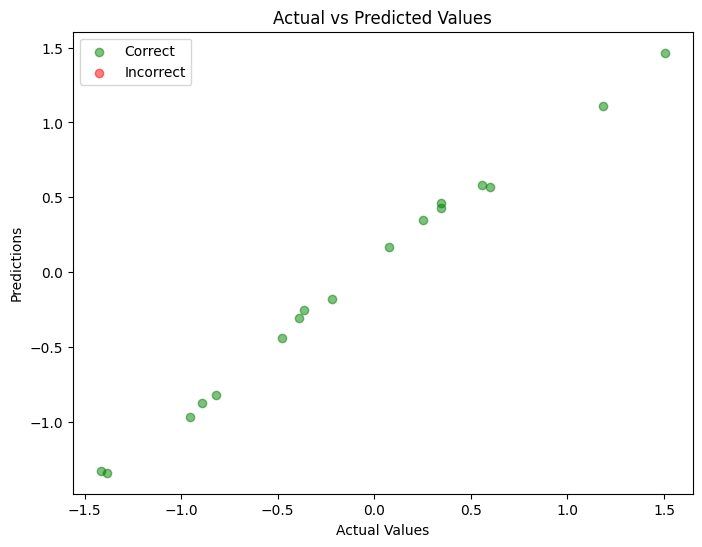

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_val and predictions are already defined
# y_val contains the actual target values, and predictions contains the model's predictions

# Calculate the absolute differences between actual values and predictions
errors = abs(y_val - predictions.flatten())

# Set a threshold for defining correct and incorrect predictions
threshold = 0.5  # Adjust this threshold based on your problem

# Create masks for correct and incorrect predictions
correct_mask = errors <= threshold
incorrect_mask = errors > threshold

# Create a scatter plot with different colors for correct and incorrect predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_val[correct_mask], predictions[correct_mask], color='green', label='Correct', alpha=0.5)
plt.scatter(y_val[incorrect_mask], predictions[incorrect_mask], color='red', label='Incorrect', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Actual vs Predicted Values')
plt.legend()  # Show legend indicating correct and incorrect points
plt.show()


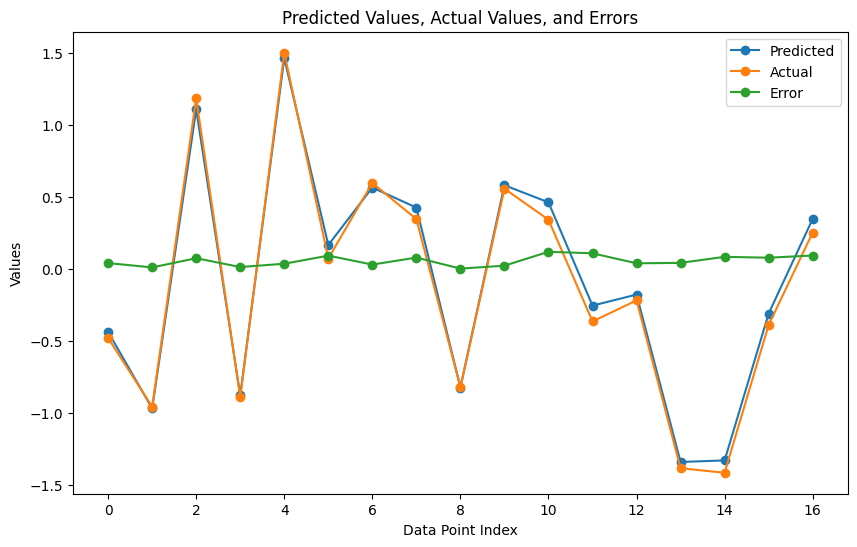

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_val and predictions are already defined
# y_val contains the actual target values, and predictions contains the model's predictions

# Calculate the absolute differences between actual values and predictions
errors = abs(y_val - predictions.flatten())

# Set up the x-axis values (indices of the data points)
x_values = range(len(y_val))

# Create a line plot for predicted values, actual values, and errors
plt.figure(figsize=(10, 6))
plt.plot(x_values, predictions.flatten(), label='Predicted', marker='o')
plt.plot(x_values, y_val, label='Actual', marker='o')
plt.plot(x_values, errors, label='Error', marker='o')

plt.xlabel('Data Point Index')
plt.ylabel('Values')
plt.title('Predicted Values, Actual Values, and Errors')
plt.legend()
plt.show()


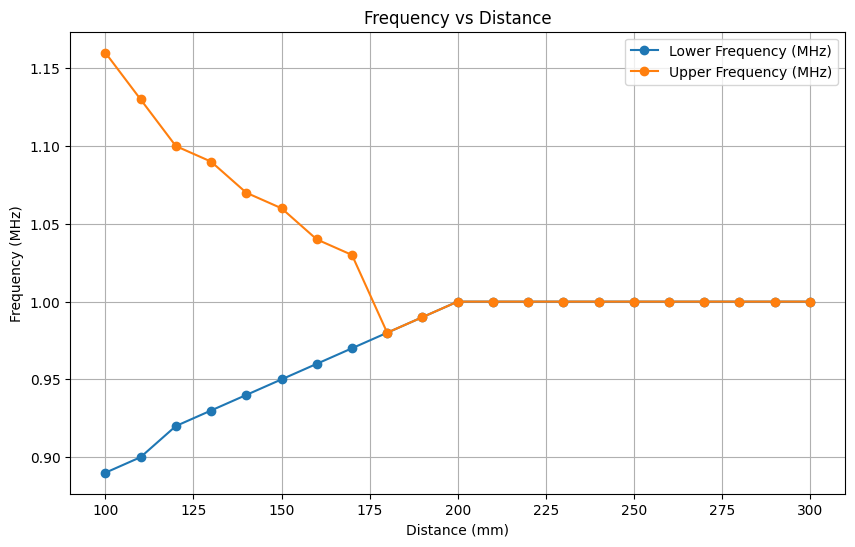

In [ ]:
import matplotlib.pyplot as plt

# Data
distance = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
lower_frequency = [0.89, 0.9, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
upper_frequency = [1.16, 1.13, 1.1, 1.09, 1.07, 1.06, 1.04, 1.03, 0.98, 0.99, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(distance, lower_frequency, marker='o', label='Lower Frequency (MHz)')
plt.plot(distance, upper_frequency, marker='o', label='Upper Frequency (MHz)')
plt.xlabel('Distance (mm)')
plt.ylabel('Frequency (MHz)')
plt.title('Frequency vs Distance')
plt.legend()
plt.grid(True)
plt.show()

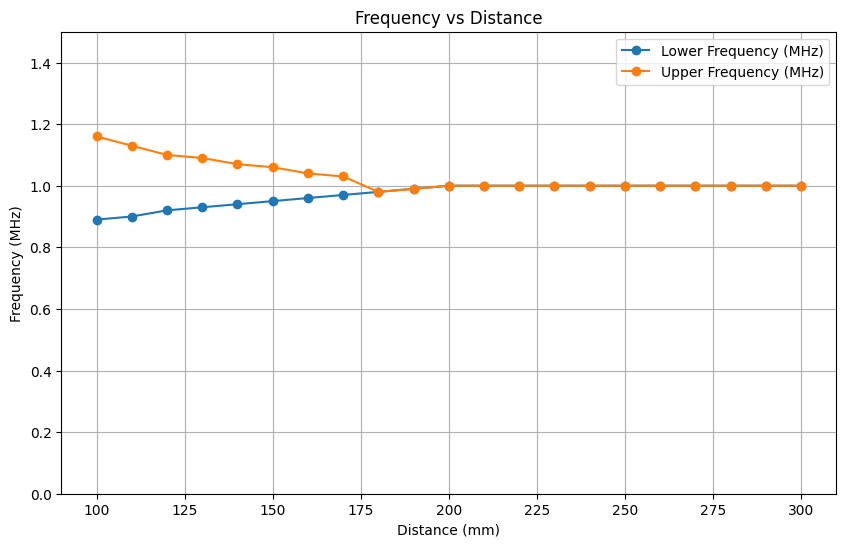

In [ ]:
import matplotlib.pyplot as plt

# Data
distance = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
lower_frequency = [0.89, 0.9, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
upper_frequency = [1.16, 1.13, 1.1, 1.09, 1.07, 1.06, 1.04, 1.03, 0.98, 0.99, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(distance, lower_frequency, marker='o', label='Lower Frequency (MHz)')
plt.plot(distance, upper_frequency, marker='o', label='Upper Frequency (MHz)')
plt.xlabel('Distance (mm)')
plt.ylabel('Frequency (MHz)')
plt.title('Frequency vs Distance')
plt.legend()
plt.grid(True)

# Set y-axis range
plt.ylim([0, 1.5])

plt.show()
